In [1]:
# Notebook demonstrating the use of quantities defined incamb.symbolic, and examples of usage
# for defining custom sources and plotting different quantities.

# Set of scalar equations implemented in CAMB, and calculation of the line-of-sight sources
# indices are: 
# g - photons, r- massless neutrinos, c - CDM, b - baryons, de - dark energy, nu - massive neutrinos

# kappa = 8 pi G, Pi is anisotropic stress, q =(rho+p)v the heat flux 
# (and for components rho_i q_i = (rho_i+p_i)v_i)
# z is the perturbation to the expansion, h perturbation to the scale factor, sigma the shear
# phi the Weyl potential, and eta the 3-curvature. Equations are in a general gauge,
# and are implemented in CAMB in the CDM frame (synchronous gauge, but using variables above). 
# There are functions to convert into Newtonian and synchronous gauge metric variables

%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import six
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
print('Using CAMB installed at %s'%(os.path.realpath(os.path.join(os.getcwd(),'..'))))
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb.symbolic import *
sympy.init_printing()
print('CAMB: %s, Sympy: %s'%(camb.__version__,sympy.__version__))

Using CAMB installed at c:\work\dist\git\camb\pycamb
CAMB: 0.1.6.1, Sympy: 1.0


'background_eqs'

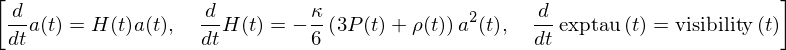

'contraints'

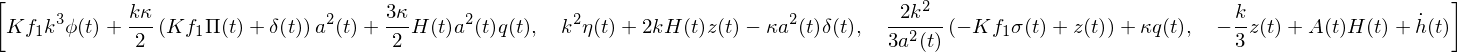

'var_subs'

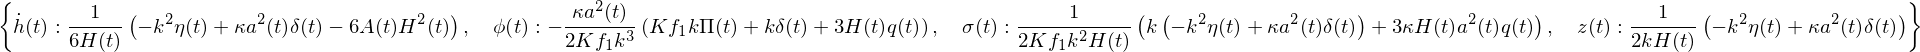

'q_sub'

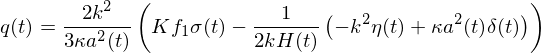

'pert_eqs'

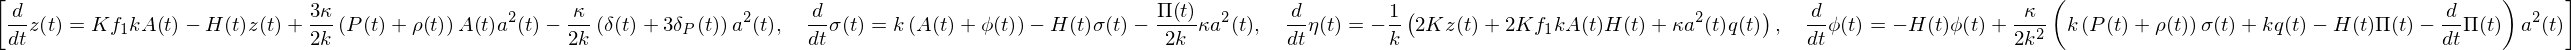

'total_eqs'

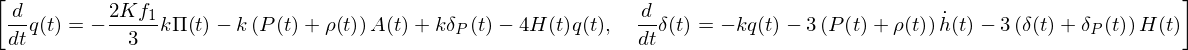

In [2]:
display('background_eqs',background_eqs)
display('contraints',constraints)
display('var_subs',var_subs)
display('q_sub',q_sub)
display('pert_eqs',pert_eqs)
display('total_eqs',total_eqs) 
#can use tot_eqs as combination of total_eqs + pert_eqs + background_eqs


Newtonian gauge variables $\Psi_N$ and $\Phi_N$ (not used in CAMB but may be useful) defined for metrix sign choices so flat metric is
$$ds^2 = a(\eta)^2\left( (1+2\Psi_N)d\eta^2 - (1-2\Phi_N)\delta_{ij}dx^idx^j\right)$$
(default, as defined by [Ma and Bertschinger](https://arxiv.org/abs/astro-ph/9506072), number count and 21cm papers, etc.) Definitions are also valid for non-flat.


The alternative definition
$$ds^2 = a(\eta)^2\left( (1+2\Psi_N)d\eta^2 - (1+2\Phi_N)\delta_{ij}dx^idx^j\right)$$
is used by [Hu et.al.](https://arxiv.org/abs/astro-ph/9709066), lensing review, etc, corresponding to a sign change in $\Phi_N$.


'Newt_vars'

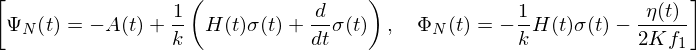

'Newtonian_subs'

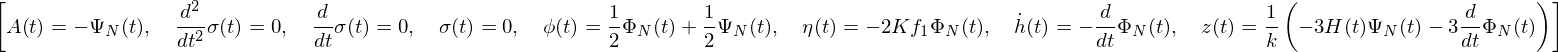

In [3]:
#Relatations for going to/from the Newtonian gauge
display('Newt_vars',Newt_vars)
display('Newtonian_subs',Newtonian_subs)

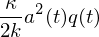

In [4]:
#e.g. get the Newtonian gauge equation for diff(Phi,t) + H*Psi 
#[eq 23b of Ma and Bertschinger, 
# noting that their (rho+P)theta = k q since q = (rho+P)v]
newtonian_gauge(subs(tot_eqs,subs(Newtonian_var_subs,
                    (diff(Phi_N,t) + H*Psi_N)).simplify().doit()))

'cdm_subs'

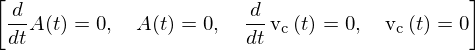

In [5]:
#CDM frame is used by CAMB, corresponding to zero acceleration or CDM velocity
display('cdm_subs', cdm_subs)
    

Define synchonous gauge variables in Ma and Bertschinger notation (generalized to non-flat)

In terms of [Hu et al](https://arxiv.org/abs/astro-ph/9709066) variables $h_L+ h_T/3 = \eta_s$ and $h_L = -h_s/6$

'synchronous_vars'

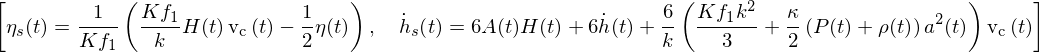

In [6]:
#General gauge-invariant form of synchronous gauge metric variables
display('synchronous_vars',synchronous_vars)

'synchronous_subs'

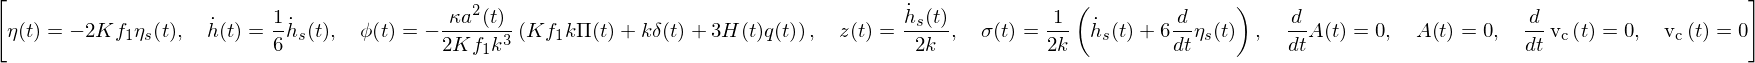

In [7]:
#To convert from general to synchronous variables can use these
display('synchronous_subs',synchronous_subs)

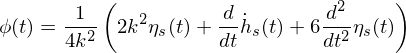

In [8]:
#Alternative pure-metric expression for phi
Eq(phi,subs(Eq(Pi,-(3*diff(eta_s,t,t)+diff(hdot_s,t)/2 + 2*(3*H*diff(eta_s,t) + H*hdot_s/2) - k**2*eta_s)/kappa/a**2),
 synchronous_gauge(subs(solve(constraints[1:],[delta,q,A]), phi_sub).rhs)).simplify())

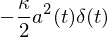

In [9]:
#Check the four synchronous gauge equations
synchronous_gauge(subs(var_subs,subs(synchronous_vars, K_fac*k**2*eta_s-H*hdot_s/2)).simplify())

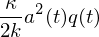

In [10]:
synchronous_gauge(subs(pert_eqs,subs(synchronous_vars, -K/2*hdot_s/k**2 + K_fac*diff(eta_s,t)).doit()))

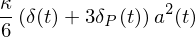

In [11]:
synchronous_gauge(subs(K_sub,subs(Friedmann,subs(var_subs,subs(total_eqs,subs(background_eqs,subs(pert_eqs,subs(var_subs,
        subs(synchronous_vars, -(diff(hdot_s,t) + H*hdot_s)/6).doit()).doit())).simplify().expand())
    ).simplify().expand())).simplify())

In [12]:
#Seems to be a factor of 2 missing in last line of eq A8 of Hu et al.
synchronous_gauge(subs(q_sub,subs(K_sub,subs(Friedmann_Kfac_subs,subs(var_subs,
    subs(tot_eqs+background_eqs, subs(var_subs,subs(pert_eqs,subs(synchronous_vars,
    3*diff(eta_s,t,t)+diff(hdot_s,t)/2 + 2*(3*H*diff(eta_s,t) + H*hdot_s/2) - k**2*eta_s).doit()).doit()).doit()))
                  .simplify()))))

'density_eqs'

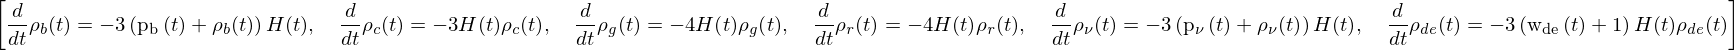

'delta_eqs'

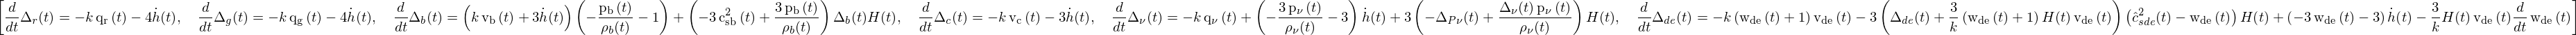

'vel_eqs'

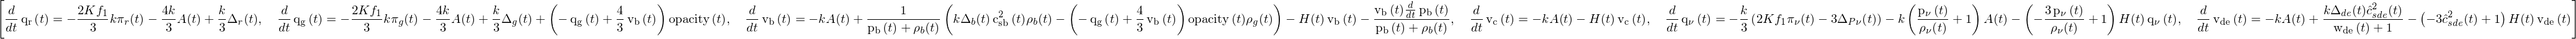

In [13]:
#Fluid components
display('density_eqs',density_eqs)
display('delta_eqs', delta_eqs)
display('vel_eqs',vel_eqs)
#can use component_eqs as combination of density_eqs + delta_eqs + vel_eqs

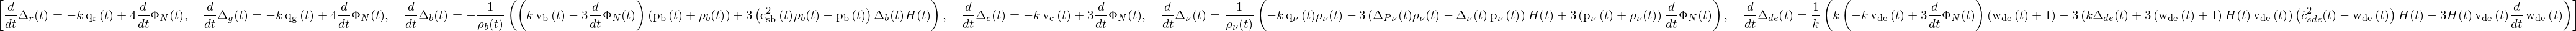

In [14]:
#e.g. can check we recover standard Newtonian gauge equations 
#(note all equations above are valid in any frame)
newtonian_gauge(delta_eqs)

'Gaude-dependent:'

'Newtonian:'

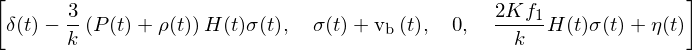

'Synchronous (CDM frame):'

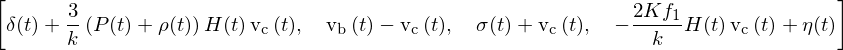

In [15]:
#Can use make_frame_invariant function to get explicit gauge-invariant equations for Newtonian (or other gauge) quantities
delta_N, v_b_N, sigma_N, eta_N = make_frame_invariant([delta,v_b, sigma, eta], 'Newtonian')
delta_sync, v_b_sync, sigma_sync, eta_sync = make_frame_invariant([delta,v_b, sigma, eta], 'CDM')

display('Gaude-dependent:', [delta, v_b, sigma, eta])
display('Newtonian:', [delta_N, v_b_N, sigma_N, eta_N]) 
display('Synchronous (CDM frame):', [delta_sync, v_b_sync, sigma_sync, eta_sync]) 

Newtonian gauge version:


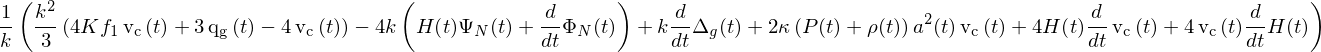

CDM frame version:


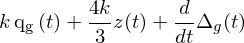

Synchronous gauge variable version:


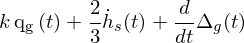

OK


In [16]:
def show_gauges(x):
    print('Newtonian gauge version:')
    display(newtonian_gauge(x))
    print('CDM frame version:')
    display(cdm_gauge(x))
    print('Synchronous gauge variable version:')
    display(synchronous_gauge(x))


def check_equation(camb_eq, view = True, p_b_zero=False):
    if view:
        show_gauges(camb_eq)
    res = simplify(subs(background_eqs +component_eqs,camb_eq.simplify()))
    res = subs(var_subs,res).simplify()
    res = subs(Friedmann_Kfac_subs, res).simplify()
    if p_b_zero: res = subs(Eq(p_b,0),res).doit().simplify()
    if res==0:
        print('OK')
    else:
        print('Non-zero, equal to:')
        display(res)

#For example CAMB implements the equation d Delta_g/dt= -k*(4/3*z+qg) in synchronous gauge. Check this works.
Delta_g_sync, z_sync, q_g_sync = make_frame_invariant([Delta_g, z, q_g], 'CDM')
check_equation(diff(Delta_g_sync,t) + k*(4*z_sync/3 + q_g_sync)) 

Newtonian gauge version:


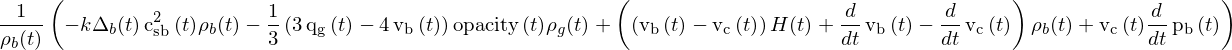

CDM frame version:


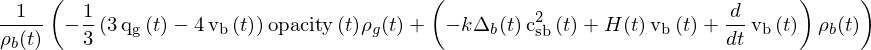

Synchronous gauge variable version:


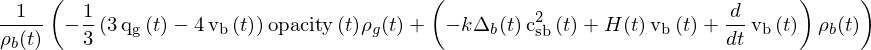

OK


In [17]:
csq_b_sync, Delta_b_sync = make_frame_invariant([csq_b, Delta_b], 'CDM')
check_equation(diff(v_b_sync,t)+H*v_b_sync
                    -csq_b_sync*k*Delta_b_sync+rho_g/rho_b*opacity*(4*v_b_sync/3-q_g_sync),p_b_zero=True)

Newtonian gauge version:


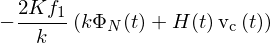

CDM frame version:


Synchronous gauge variable version:


In [18]:
#can see how a synchronous gauge variable used in CAMB can be obtained in Newtonian gauge, e.g.
show_gauges(eta_sync)

Newtonian gauge version:


CDM frame version:


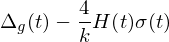

Synchronous gauge variable version:


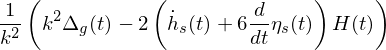

In [19]:
Delta_g_N = make_frame_invariant(Delta_g, 'Newtonian')
show_gauges(Delta_g_N)

'tot_subs'

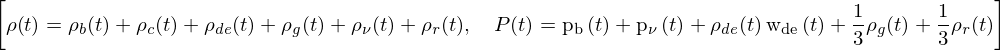

'tot_pert_subs'

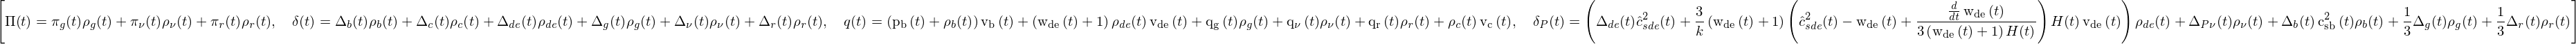

In [20]:
#Relations between components and totals
display('tot_subs',tot_subs)
display('tot_pert_subs',tot_pert_subs)

'hierarchies'

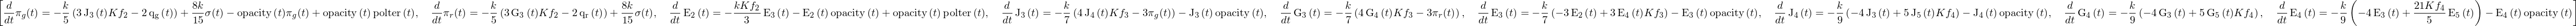

In [21]:
#First few equations in Boltzmann hierarchies for L>=2 (J photon, G neutrino)
display('hierarchies',hierarchies)

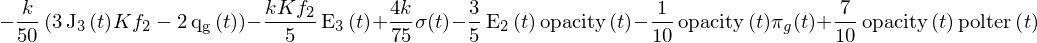

In [22]:
# polter is the quadrupole source. Need its derivatives for line-of-sight solution.
polterdot = subs(hierarchies,diff(polter_t,t))
polterdot

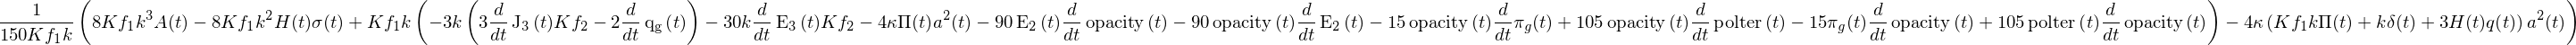

In [23]:
polterddot = subs(phi_sub,diff(polterdot,t).subs(diff(sigma,t),dsigma).simplify()).simplify()
polterddot

In [24]:
monopole_source, ISW, doppler, quadrupole_source = get_scalar_temperature_sources()

In [25]:
#These are definitions used in CAMB to get the various sources for the temperature
print(camb_fortran(dphi, 'phidot'))
print(camb_fortran(dsigma, 'sigmadot'))
print(camb_fortran(diff(polter_t,t), 'polterdot'))
print(camb_fortran(polterddot, 'polterddot'))
print(camb_fortran(2*diff(phi,t)*exptau,'ISW'))
print(camb_fortran(monopole_source, 'monopole_source'))
print(camb_fortran(doppler, 'doppler'))
print(camb_fortran(quadrupole_source, 'quadrupole_source'))


phidot = (1.0d0/2.0d0)*(-adotoa*dgpi - 2*adotoa*k**2*phi + dgq*k &
    -diff_rhopi + k*sigma*(gpres + grho))/k**2
sigmadot = -adotoa*sigma - 1.0d0/2.0d0*dgpi/k + k*phi
polterdot = (1.0d0/10.0d0)*pigdot + (3.0d0/5.0d0)*Edot(2)
polterddot = -2.0d0/25.0d0*adotoa*dgq/(k*Kf(1)) - &
    4.0d0/75.0d0*adotoa*k*sigma - 4.0d0/75.0d0*dgpi - &
    2.0d0/75.0d0*dgrho/Kf(1) + dopacity*(-1.0d0/10.0d0*pig + &
    (7.0d0/10.0d0)*polter - 3.0d0/5.0d0*E(2)) &
    -3.0d0/50.0d0*k*octgdot*Kf(2) + (1.0d0/25.0d0)*k*qgdot - &
    1.0d0/5.0d0*k*Edot(3)*Kf(2) + opacity*(-1.0d0/10.0d0*pigdot + &
    (7.0d0/10.0d0)*polterdot - 3.0d0/5.0d0*Edot(2))
ISW = 2*exptau*phidot
monopole_source = (1.0d0/4.0d0)*visibility*(-4*etak + k*(clxg + &
    8*phi)*Kf(1))/(k*Kf(1))
doppler = (dvisibility*(sigma + vb) + visibility*(sigmadot + vbdot))/k
quadrupole_source = (5.0d0/8.0d0)*(3*ddvisibility*polter + &
    6*dvisibility*polterdot + visibility*(k**2*polter + &
    3*polterddot))/k**2


In [26]:
#internal_consistency_checks()

In [27]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, As=2e-9, ns=0.95, tau=0.055)
from matplotlib import rcParams
rcParams.update( {'axes.labelsize': 14,
              'font.size': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 13,
              'ytick.labelsize': 13})
cl_label= r'$\ell(\ell+1)C_\ell/2\pi\quad [\mu {\rm K}^2]$'

'Temperature monopole source in general'

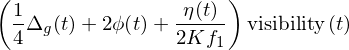

'Temperature monopole source in Newtonian gauge'

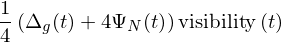

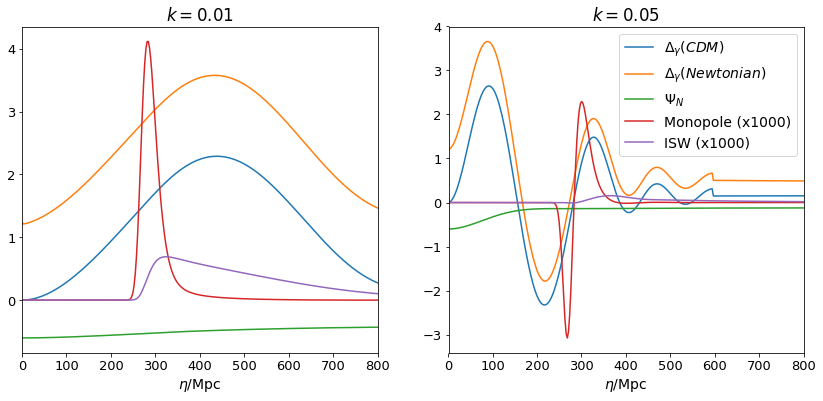

In [28]:
#Example of plotting the time evolution of Newtonian gauge variables and the monopole sources 

data= camb.get_background(pars)
conformal_times = np.linspace(1, 800, 300)
ks = [0.01,0.05]
Delta_g_N = make_frame_invariant(Delta_g, 'Newtonian')
display('Temperature monopole source in general', monopole_source)
display('Temperature monopole source in Newtonian gauge', newtonian_gauge(monopole_source))

ev = data.get_time_evolution(ks, conformal_times, ['delta_photon', Delta_g_N, Psi_N, monopole_source, ISW])
_, axs= plt.subplots(1,2, figsize=(14,6))
for i, ax in enumerate(axs):
    ax.plot(conformal_times,ev[i,:, 0])
    ax.plot(conformal_times,ev[i,:, 1])
    ax.plot(conformal_times,ev[i,:, 2])

    ax.plot(conformal_times,ev[i,:, 3]*1000)
    ax.plot(conformal_times,ev[i,:, 4]*1000)

    ax.set_title('$k= %s$'%ks[i])
    ax.set_xlabel(r'$\eta/\rm{Mpc}$');
    ax.set_xlim(conformal_times[0], conformal_times[-1]);
plt.legend([r'$\Delta_\gamma (CDM)$', r'$\Delta_\gamma (Newtonian)$',r'$\Psi_N$',
            r'Monopole (x1000)', r'ISW (x1000)']);

In [29]:
# You can also calculate power spectra for custom source functions.
# For example, let's split up the standard temperature result into the various sub-terms,
# and see how they contribute to the total 

early_ISW = sympy.Piecewise( (ISW, 1/a-1> 30),(0, True))  #redshift > 30
late_ISW = ISW - early_ISW

names = ['mon','ISW','eISW','LISW','dop', 'Q']
camb.set_custom_scalar_sources([monopole_source, ISW,early_ISW, late_ISW,doppler,quadrupole_source], 
        source_names =names)

data= camb.get_results(pars)
dic = data.get_cmb_unlensed_scalar_array_dict(CMB_unit='muK')


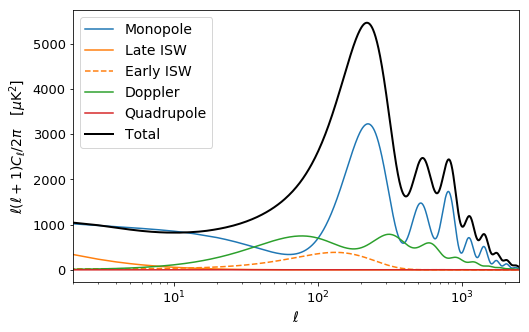

In [30]:
ls =np.arange(dic['TxT'].shape[0])
plt.figure(figsize=(8,5))
plt.semilogx(ls,dic['monxmon'], color='C0')
plt.semilogx(ls,dic['LISWxLISW'], color='C1')
plt.semilogx(ls,dic['eISWxeISW'], ls='--', color='C1')
plt.semilogx(ls,dic['dopxdop'],color='C2')
plt.semilogx(ls,dic['QxQ'], color='C3')
plt.semilogx(ls,dic['TxT'], lw=2, color='k')
plt.xlabel('$\ell$')
plt.ylabel(cl_label)
plt.xlim(2, ls[-1])
plt.legend(['Monopole','Late ISW','Early ISW','Doppler','Quadrupole', 'Total'], loc = 'upper left');

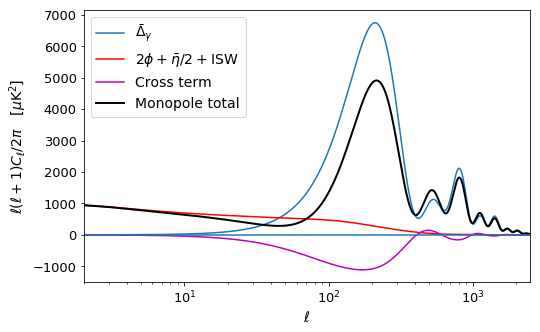

In [31]:
# The monopole sources can also be decomposed in various different ways, 
# e.g. in terms of comoving-frame quantities: 

# a comoving photon density term (important on sub-horizon scales),
dg = make_frame_invariant(Delta_g/4*visibility, frame='comoving') 

# plus a sum of potential and comoving curvature terms, and ISW
rest=make_frame_invariant(monopole_source - dg, frame=q) +ISW

names = ['dg','rest','mon']
camb.set_custom_scalar_sources([dg, rest, monopole_source+ISW], source_names =names)
data= camb.get_results(pars)
mondic = data.get_cmb_unlensed_scalar_array_dict(CMB_unit='muK')

ls =np.arange(dic['TxT'].shape[0])

plt.figure(figsize=(8,5))
plt.semilogx(ls,mondic['dgxdg'])
plt.semilogx(ls,mondic['restxrest'], color='r')
plt.semilogx(ls,mondic['restxdg'], color='m')
plt.semilogx(ls,mondic['monxmon'], color='k', lw=2)
plt.xlabel('$\ell$')
plt.ylabel(cl_label)
plt.axhline(0)

plt.xlim(2, ls[-1])
plt.legend([r'$\bar{\Delta}_\gamma$',r'$2\phi+\bar{\eta}/2 + {\rm ISW}$',
             'Cross term', 'Monopole total']);

We now demonstrate how to calculate non-standard sources, e.g. as needed to 
calculate corrections to the standard lensing result from emission angle and
time delay effects (see [arXiv:1706.02673](http://arxiv.org/abs/arXiv:1706.02673), as now implemeted in camb in the camb.emission_angle module).

In [32]:
#Various sources for emission angle and time delay, from recombination and reionization

chi = tau0-t #assume flat

emission_sources = {
  'vperp' :  -(sigma+v_b)*visibility/k/chi,
  'emit'  : 15*diff(polter*visibility,t)/8/k**2/chi,
  'delay' : 15*diff(polter*visibility,t)/8/k**2/chi**2 *(tau0 - tau_maxvis),
  'E'     : scalar_E_source}

sources ={}
for key, source in list(emission_sources.items()):
    sources[key+'1'] = sympy.Piecewise((source,1/a-1>30),(0, True))  #recombination
    sources[key+'2'] =  sympy.Piecewise((source,1/a-1<=30),(0, True))  #reionization  
    
camb.set_custom_scalar_sources(sources, source_ell_scales={'E1':2,'E2':2})
data= camb.get_results(pars)
dic = data.get_cmb_unlensed_scalar_array_dict(CMB_unit='muK')

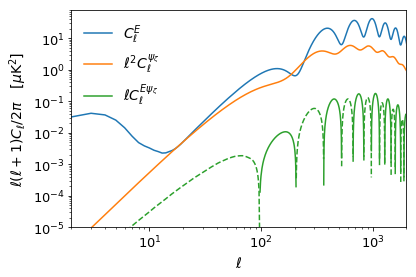

In [33]:
#Plot polariazation potentials

ls = np.arange(dic['ExE'].shape[0])
lfac = np.sqrt(ls*(ls+1))
plt.loglog(dic['ExE'])
plt.loglog(dic['emit1xemit1']*ls**2)
plt.loglog(dic['emit1xE1']*ls, color='C2')
plt.loglog(-dic['emit1xE1']*ls,ls ='--',color='C2')

plt.xlim(2,2000)
plt.ylim([1e-5,80])
plt.legend(['$C_\ell^E$',r'$\ell^2 C_\ell^{\psi_\zeta}$',r'$\ell C_\ell^{E\psi_\zeta}$'],
           loc='upper left', frameon=False)
plt.xlabel(r'$\ell$')
plt.ylabel(cl_label);

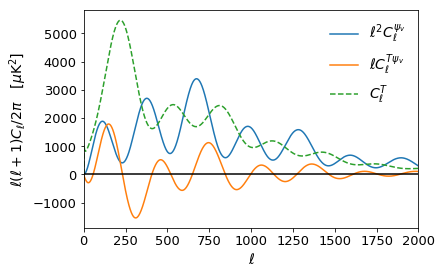

In [34]:
#temperature velocity potentials

plt.plot(ls,ls**2*dic['vperp1xvperp1'],color='C0')
plt.plot(ls,ls*dic['vperp1xT'],color='C1')
plt.plot(ls,dic['TxT'],color='C2',ls='--')
#plt.plot(ls,np.exp(-2*0.0581)*lsampvel**2*vel_deltavis_cl_sp(lsampvel)*norm,ls=':',color='C0')
plt.axhline(0,color='k')
plt.xlim([0,2000])
plt.xlabel(r'$\ell$')
plt.ylabel(cl_label)
plt.legend([r'$\ell^2 C^{\psi_v}_\ell$',r'$\ell C^{T\psi_v}_\ell$',r'$C^{T}_\ell$'],
            frameon=False);

In [35]:
#The camb.emission_angle module uses the above to calculate BB from emission angle and time delay
#e.g. compare BB from lensing, field rotation and emission angle/time delay
from camb import emission_angle
from camb import postborn
%time BB = emission_angle.get_emission_delay_BB(pars, lmax=3500)
%time Bom=postborn.get_field_rotation_BB(pars, lmax=3500)

Wall time: 35.3 s
Wall time: 1min 3s


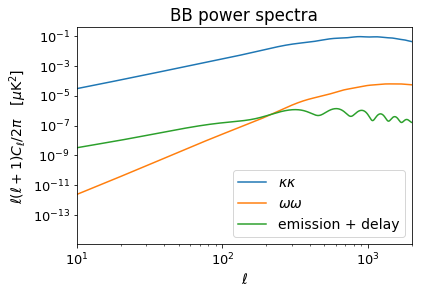

In [36]:
plt.loglog(ls, data.get_lensed_scalar_cls(2500, CMB_unit = 'muK')[:,2])
plt.loglog(ls,Bom(ls))
plt.loglog(ls,BB(ls))
plt.xlim([10, 2000])
plt.ylabel(cl_label)
plt.xlabel(r'$\ell$')
plt.legend([r'$\kappa\kappa$', r'$\omega\omega$','emission + delay']);
plt.title('BB power spectra');